In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

Using TensorFlow backend.


In [2]:
seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

W1007 10:33:50.981981 15628 deprecation_wrapper.py:119] From c:\users\fengzhiheng\anaconda3\envs\kerasenv\lib\site-packages\keras\backend\tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1007 10:33:51.030850 15628 deprecation_wrapper.py:119] From c:\users\fengzhiheng\anaconda3\envs\kerasenv\lib\site-packages\keras\backend\tensorflow_backend.py:507: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1007 10:33:51.044813 15628 deprecation_wrapper.py:119] From c:\users\fengzhiheng\anaconda3\envs\kerasenv\lib\site-packages\keras\backend\tensorflow_backend.py:3831: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1007 10:33:51.145544 15628 deprecation_wrapper.py:119] From c:\users\fengzhiheng\anaconda3\envs\kerasenv\lib\site-packages\keras\backend\tensorflow_backend.py:167: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_de

In [4]:
def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)
    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)
        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1
            # Size of the square
            w = np.random.randint(2, 4)
            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1
                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1
    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [5]:
noisy_movies, shifted_movies = generate_movies(n_samples=1200)

In [6]:
type(noisy_movies)

numpy.ndarray

In [7]:
noisy_movies.shape

(1200, 15, 40, 40, 1)

In [5]:
#将数据保存到一个指定的目录下
noisy_moviesPath = 'D:/Data/conv_lstm_data/noisy_movies/'
shifted_moviesPath = 'D:/Data/conv_lstm_data/shifted_movies/'
dataPath = 'D:/Data/conv_lstm_data/data/'
#通过imageJ观察保存下载的图片


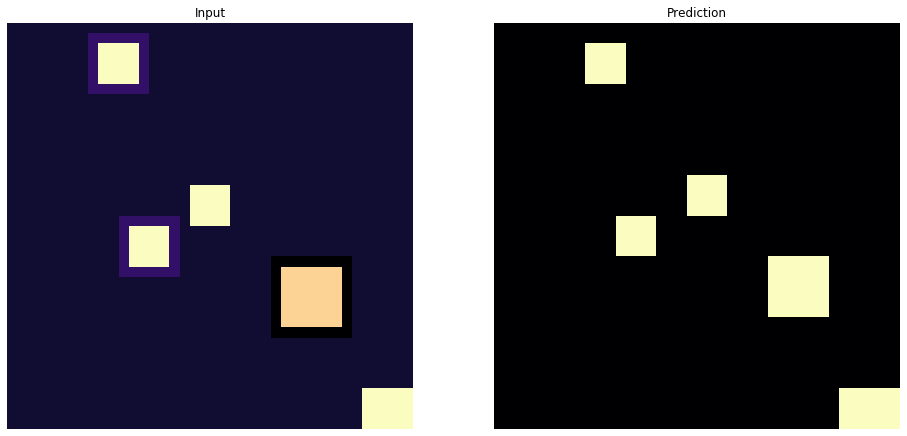

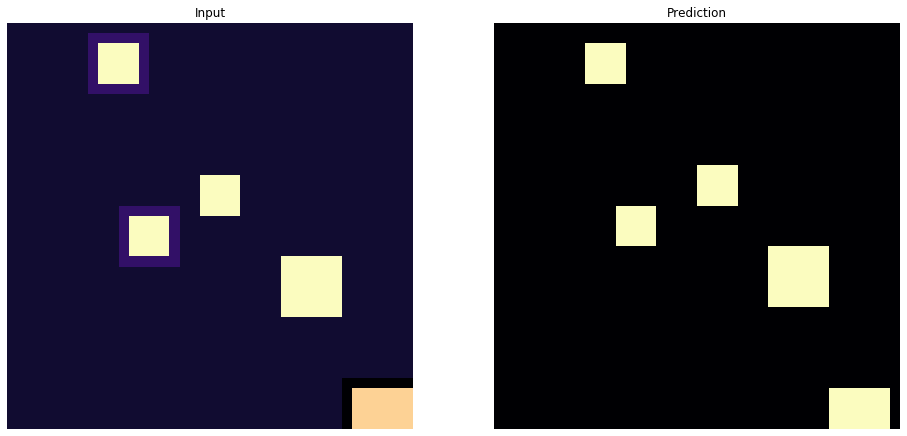

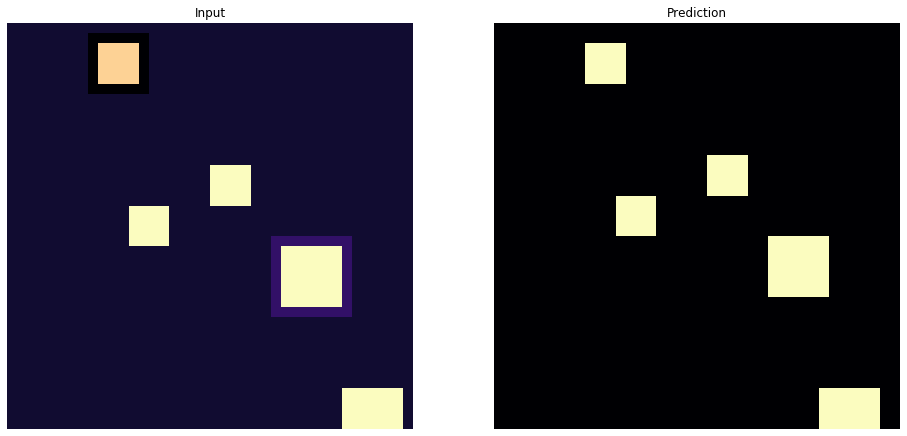

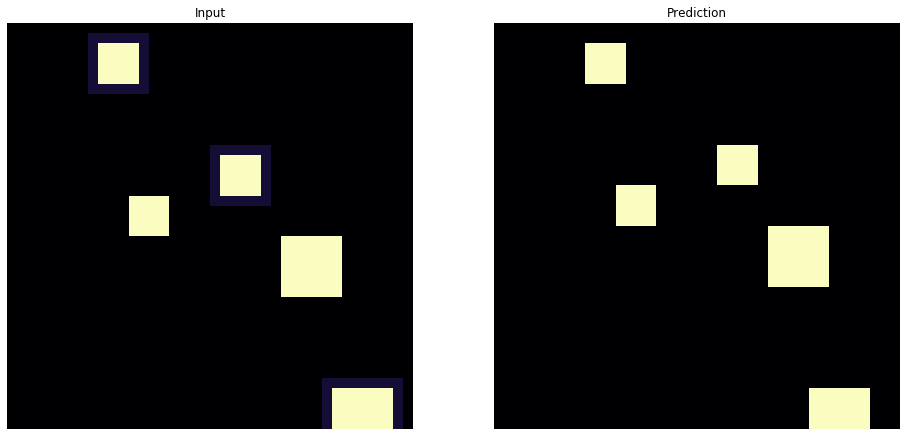

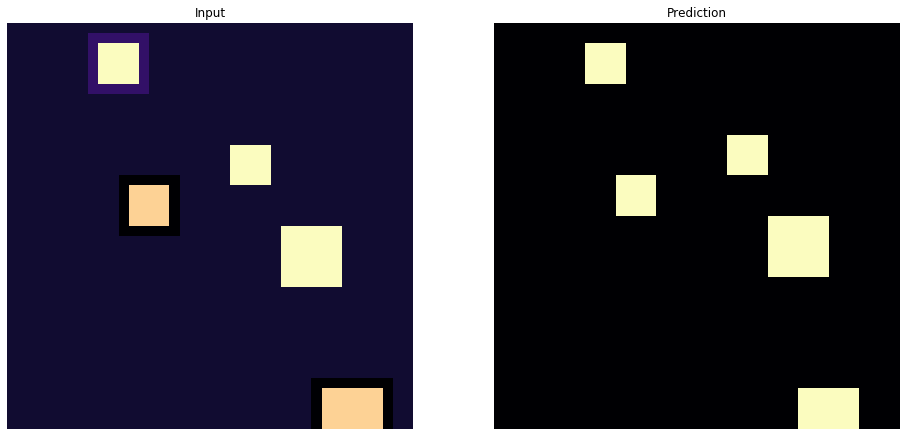

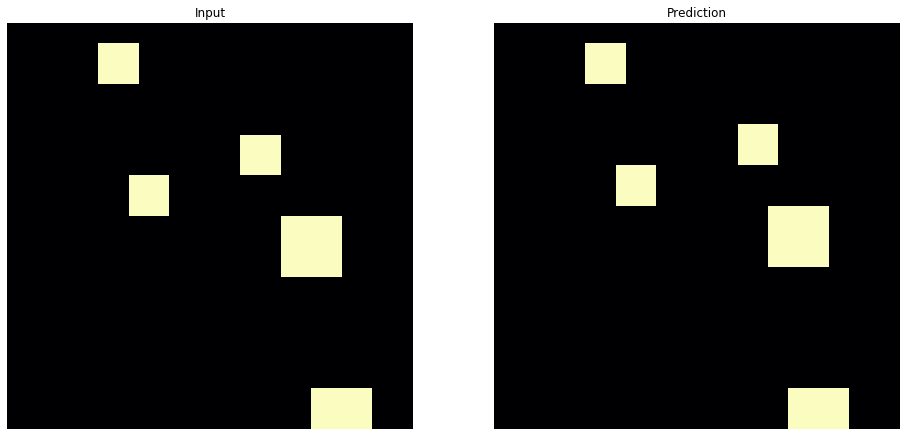

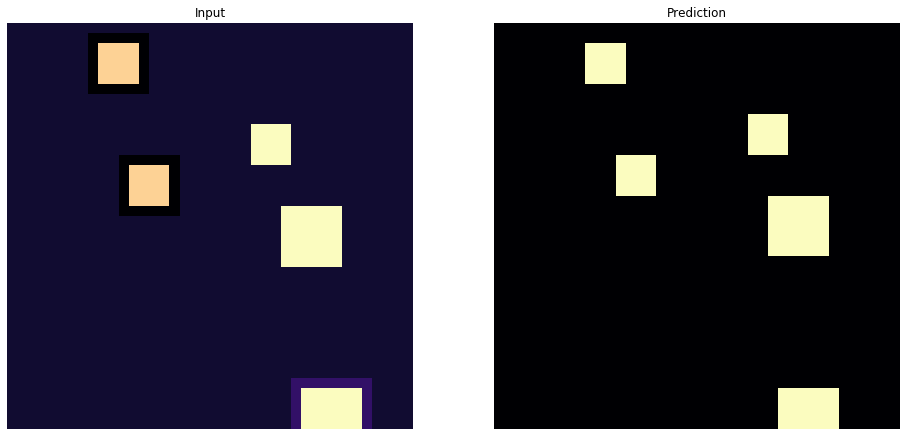

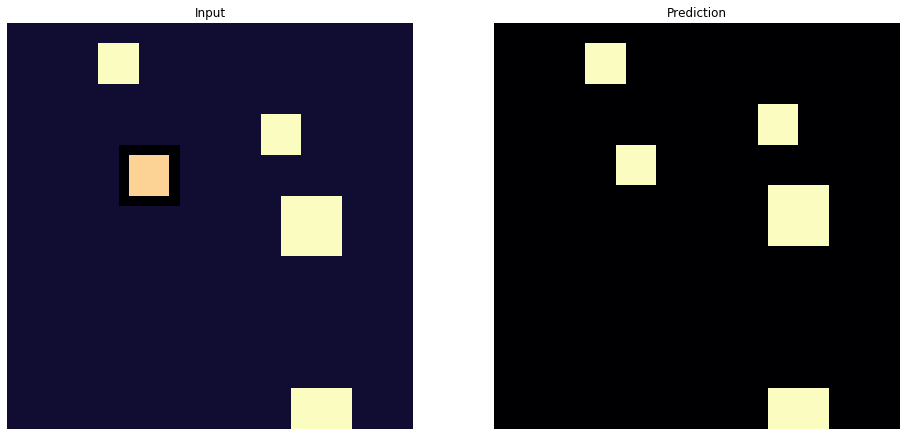

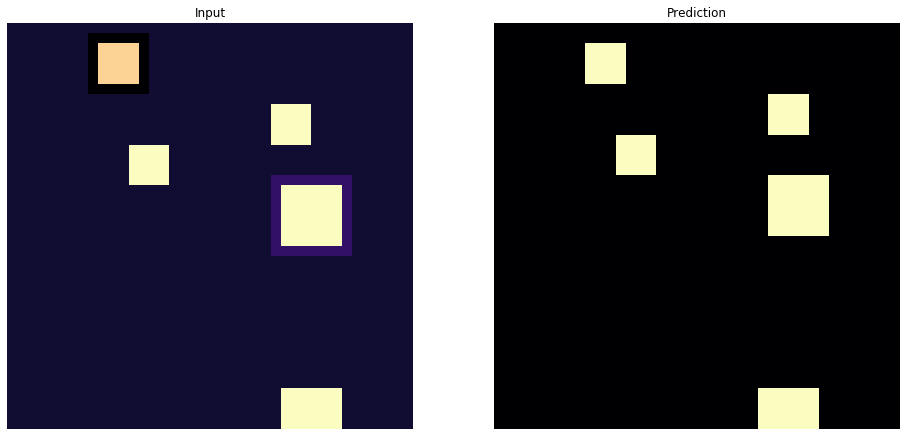

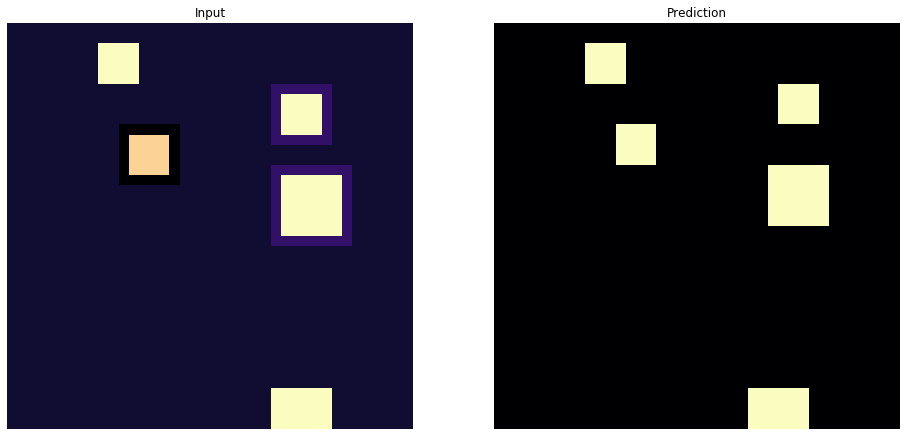

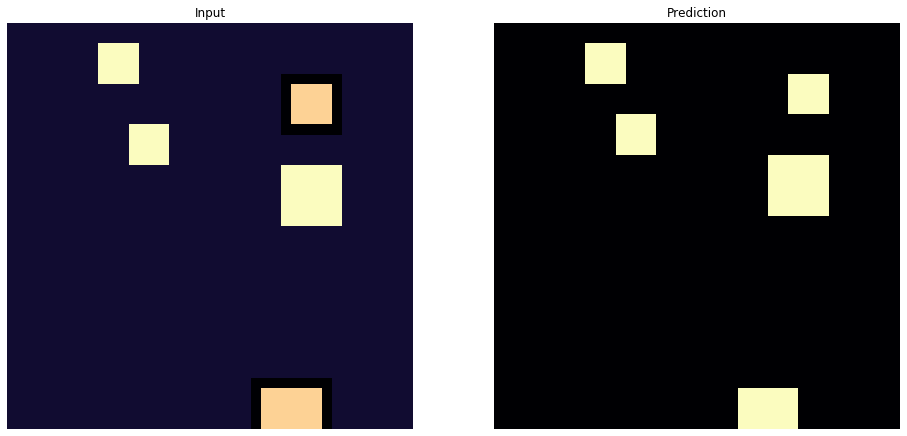

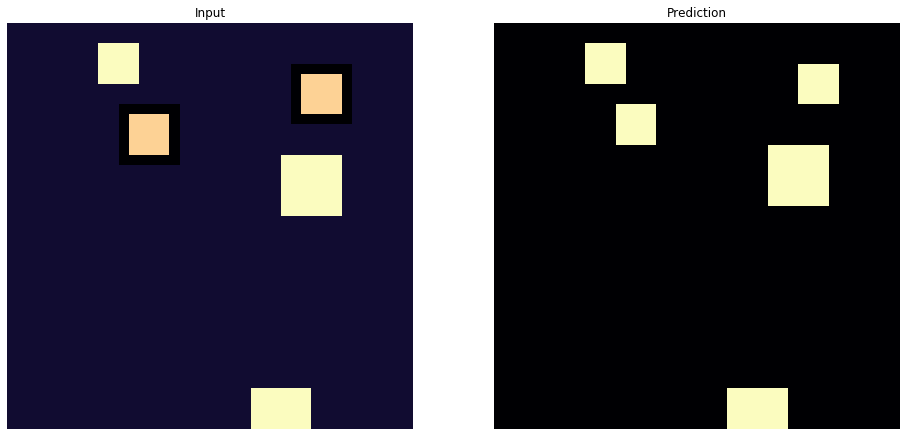

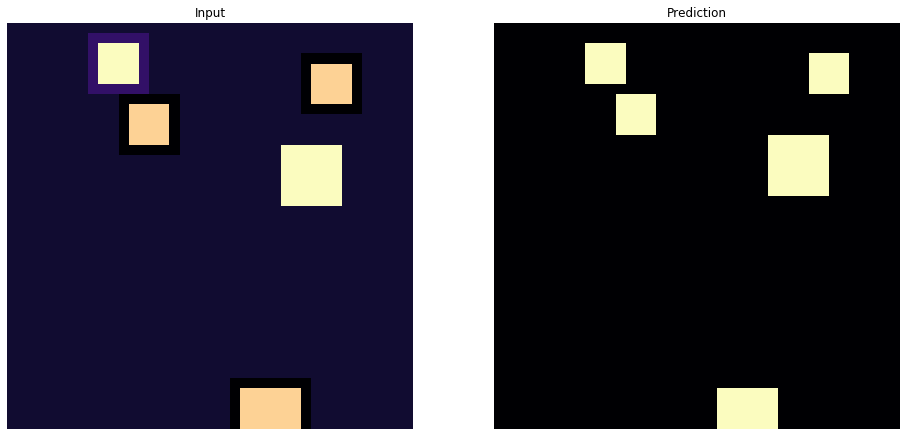

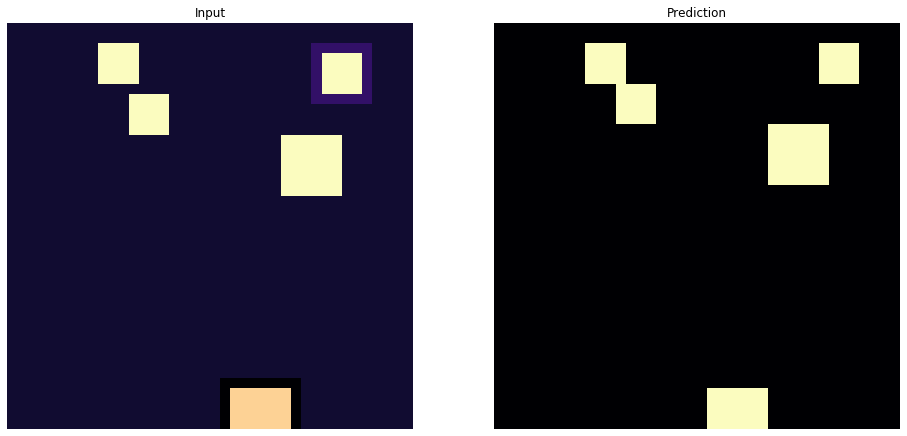

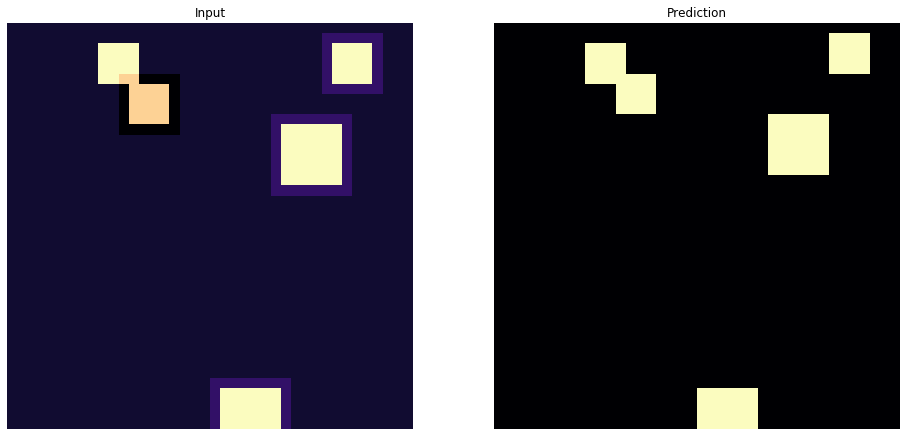

In [9]:
#获取帧数
frameNum = noisy_movies.shape[0]
#写个for循环，保存每一帧
for i in range(15):    
    tmpNoiseImage = noisy_movies[1, i, ::, ::, 0]#取的是每一个视频中的第1帧
    tmpShiftedImage = shifted_movies[1, i, ::, ::, 0]
    # Let's look at the results.
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(tmpNoiseImage,cmap="magma")
    plt.axis('off') # 不显示坐标轴
    plt.title('NoiseImage');
    plt.subplot(1,2,2)
    plt.imshow(tmpShiftedImage,cmap="magma")
    plt.axis('off') # 不显示坐标轴
    plt.title('ShiftedImage');
    plt.savefig(dataPath+'%i_sourceVideo.png' % (i + 1))

In [27]:
def showArray(array,axis=0):
    frameNum = array.shape[axis]
    for i in range(frameNum):    
        tmpNoiseImage = array[0, i, ::, ::, 0]#取的是每一个视频中的第1帧
        plt.figure(figsize=(16,8))
        plt.subplot(1,1,1)
        plt.imshow(tmpNoiseImage,cmap="magma")
        plt.axis('off') # 不显示坐标轴
        plt.title('Image');


In [13]:
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]
aa = track[np.newaxis, ::, ::, ::, ::]
aa.shape

(1, 7, 40, 40, 1)

In [7]:
track.shape

(7, 40, 40, 1)

In [10]:
tmp = np.newaxis
type(tmp)

NoneType

In [11]:
print(seq.summary()) # Summarize Model，能够显示出来网络的结果，但是是文字形式

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 40, 40, 40)  59200     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
__________

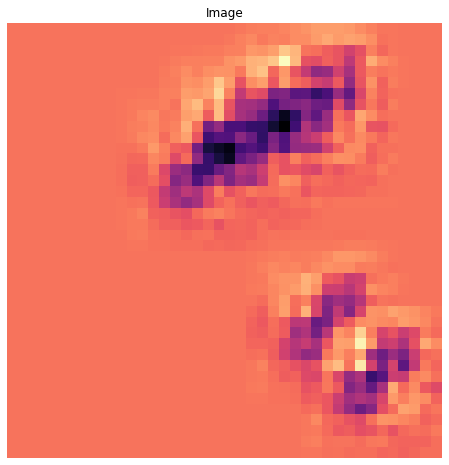

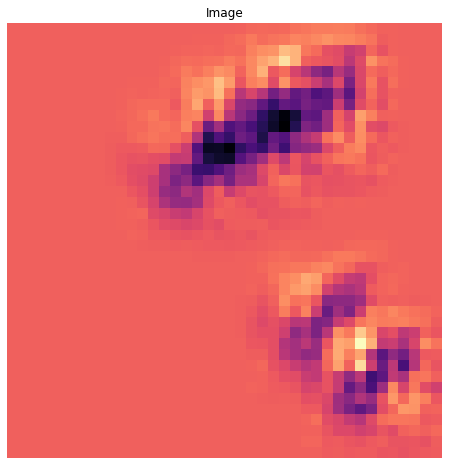

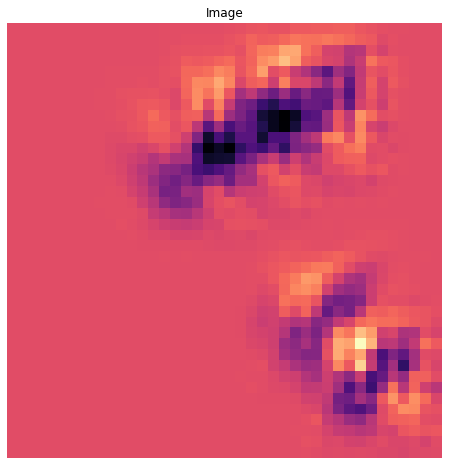

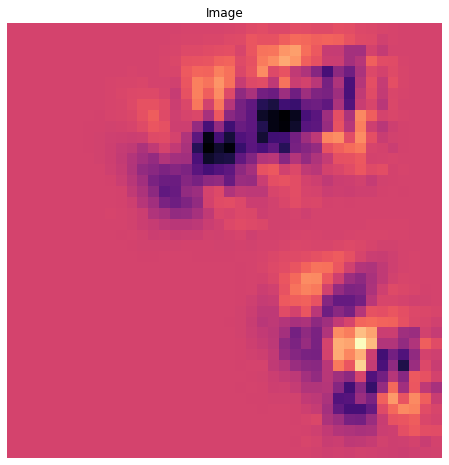

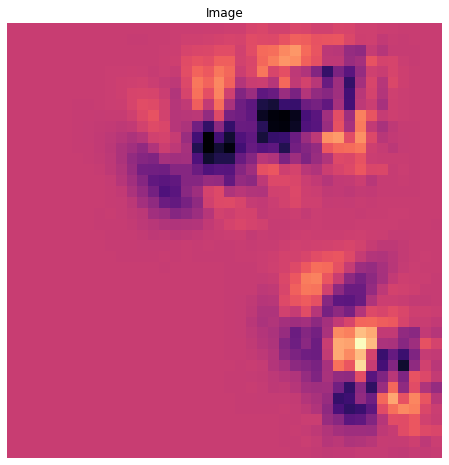

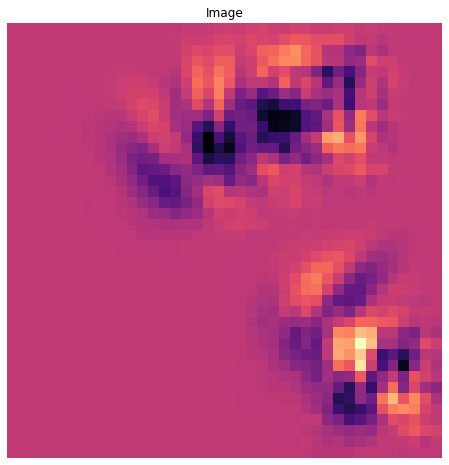

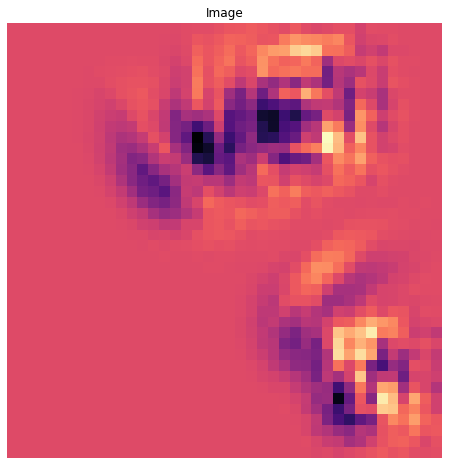

In [28]:
new_pos = seq.predict(aa)

showArray(new_pos,axis=1)


In [29]:
new_pos.shape

(1, 7, 40, 40, 1)

In [30]:
new = new_pos[::, -1, ::, ::, ::]
new.shape

(1, 40, 40, 1)

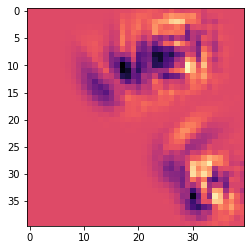

In [33]:
plt.imshow(new[0,::,::,0],cmap="magma")